<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/ensemble/voting/01_voting_soft_hard_clasification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
import warnings
from unicodedata import normalize

import random

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


from sklearn.metrics import (
    f1_score
)

from sklearn.ensemble import VotingClassifier

# **Info**
---
**@By**: **Steven Bernal**

**@Nickname**: **Kaiziferr**

**@Git**: https://github.com/Kaiziferr

The purpose of this mini project is to demonstrate the ability to assemble different models to make a prediction. Validating a better performance than what each model could individually.

# **Config**
---

In [93]:
sns.set(style="darkgrid")
pd.set_option('display.float_format', '{:,.5f}'.format)
title_data = 'Materiales extraidos en Colombia'
random_seed=12354
warnings.filterwarnings("ignore")

# **Functions**

---




In [94]:
def normalize_word(word)->str:
  """Normaliza palabras"""
  word = word.replace(' ', '_')
  find_guion = word.find('_')
  list_word = []
  if find_guion:
    list_word = [w for w in word.split('_') if w != '']
  else:
    list_word = word
  word = list(map(lambda x: x.lower(), list_word))
  word = [normalize('NFKD', c).encode('ASCII', 'ignore').decode() for c in word]
  word = "_".join(word)
  return word


def normalize_name_columns(columns):
  """Normaliza columnas"""
  columns = list(map(lambda x: normalize_word(x), columns))
  return columns


def generate_colors(paleta:str="Set1", n_colors:int=15)-> tuple:
  """color generator"""
  try:
    cmap = sns.color_palette(paleta, n_colors).as_hex()
    list_camp = ListedColormap(cmap)
    return cmap, list_camp
  except Exception as e:
    print(e)

def plot_bar(data:pd.DataFrame, paleta:list=None, figsize_x:int=8, figsize_y:int=5,
             fontsize:int=15, **kwards)->None:
  """Grafica un diagrama de barras con multiples caracteristicas"""
  try:
    paleta = paleta if paleta !=None else generate_colors()[0]
    v = kwards
    ejeX = v["ejeX"]

    fig, ax = plt.subplots(figsize = (figsize_x, figsize_y))
    fig.suptitle(f'Diagrama de barras {v["title"]}', fontsize=fontsize)

    if type(ejeX) == str:
      sns.countplot(x=ejeX, data=data, ax = ax, palette=paleta)
    else:
      ejeX = v['ejeX'][0]
      sns.countplot(x=ejeX, hue=v['ejeX'][1], data=data, ax=ax, palette=paleta)

    ax.set_ylabel(v['ejey'], size = 12)
    ax.set_xlabel(ejeX, size=fontsize-3)

    ax.set_xticklabels(ax.get_xticklabels(), fontsize = fontsize-3)
    for p in ax.patches:
      try:
        height = int(p.get_height())
        height_text = height
        if kwards['p'] == True:
          percentage = round(height/data.shape[0], 5)
          height_text = f'{height} ({percentage})'
        ax.text(p.get_x()+p.get_width()/2., height + 1, height_text, ha="center")
      except:
        pass

  except Exception as e:
    print(e)

regiones = {
    'Amazonia': [
        "Amazonas",
        "Caqueta",
        "Guainia",
        "Guaviare",
        "Putumayo",
        "Vaupes"
    ], 'Andina': [
        "Antioquia",
        "Boyaca",
        "Caldas",
        "Cundinamarca",
        "Huila",
        "Norte de Santander",
        "Quindio",
        "Risaralda",
        "Santander",
        "Tolima",
        'Bogota, D.C.'
    ], 'Caribe':[
        "Atlantico",
        "Bolivar",
        "Cesar",
        "Cordoba",
        "La Guajira",
        "Magdalena",
        "Sucre"
    ], 'Orinoquia': [
        "Arauca",
        "Casanare",
        "Meta",
        "Vichada",

    ], 'Pacifico':[
        "Valle del Cauca",
        "Choco",
        "Cauca",
        "Nariño"
    ]
}

def set_department(department:str):
  """assignment of the department"""
  se = department
  for i in regiones.items():
      if department in i[1]:
        se =  i[0]
  return se

# **Data**

---



The dataset is the extraction of resources from the Colombian territory.

In [95]:
url_master =  'https://drive.google.com/uc?id='
url_minero='https://drive.google.com/file/d/10_YGM_dOKzzLsLNkfB_bN5YeLgDHcrUZ/view?usp=sharing'

url_minero =  url_master + url_minero.split('/')[-2]
data_miner = pd.read_csv(url_minero, dtype=str)
data_miner.head(2)

,Municipio Productor,Departamento,Recurso Natural,Nombre Del Proyecto,Año Produccion,Trimestre,Unidad Medida,Tipo Contraprestacion,Valor Contraprestacion,Cantidad Producción
0,Medellin,Antioquia,ARCILLAS,PRODUCTORES,2018,Trimestre 4,TONELADAS,REGALIAS,614258,0
1,Medellin,Antioquia,ARCILLAS CERAMICAS,PRODUCTORES,2014,Trimestre 4,TONELADAS,REGALIAS,2036781,14381


**Normalization**

The column names are normalize, as well as their data types.

In [96]:
data_miner.columns = normalize_name_columns(data_miner.columns)

In [97]:
data_miner.columns = [
    "producing_municipality",
    "department",
    "natural_resource",
    "project_name",
    "production_year",
    "quarter",
    "unit_of_measure",
    "type_of_counterpart",
    "counterpart_value",
    'production_quantity'
]

**Data Type Setting**

In [98]:
data_miner[[
    'production_year'
]] = data_miner[[
    'production_year'
]].astype('int32')

In [99]:
data_miner[[
    'counterpart_value',
    'production_quantity'
]] = data_miner[[
    'counterpart_value',
    'production_quantity'
]].astype('float64')

**Info**

In [100]:
data_miner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55257 entries, 0 to 55256
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   producing_municipality  55257 non-null  object 
 1   department              55257 non-null  object 
 2   natural_resource        55257 non-null  object 
 3   project_name            55257 non-null  object 
 4   production_year         55257 non-null  int32  
 5   quarter                 55257 non-null  object 
 6   unit_of_measure         55257 non-null  object 
 7   type_of_counterpart     55257 non-null  object 
 8   counterpart_value       55257 non-null  float64
 9   production_quantity     55257 non-null  float64
dtypes: float64(2), int32(1), object(7)
memory usage: 4.0+ MB


There are no explicit null values ​​present.

The last four years are used. 2018, 2019, 2020, 2021

In [101]:
data_miner.production_year.value_counts().reset_index().T

,0,1,2,3,4,5,6,7,8,9,10,11
production_year,2013,2017,2018,2016,2019,2014,2015,2012,2022,2021,2020,2023
count,5587,5343,5305,5285,5133,4869,4817,4307,4150,4141,3965,2355


To narrow down the problem, records of the extraction of precious metals such as GOLD, SILVER, and PLATINUM  used

In [102]:
new_data = data_miner[
    (data_miner['unit_of_measure'] == 'GRAMOS') &
    (data_miner.production_year>=2018) &
    (data_miner.production_year<=2021)
]

In [103]:
new_data.head()

,producing_municipality,department,natural_resource,project_name,production_year,quarter,unit_of_measure,type_of_counterpart,counterpart_value,production_quantity
166,Abejorral,Antioquia,ORO,PRODUCTORES,2020,Trimestre 1,GRAMOS,REGALIAS,"133,820.00000",25.00000
185,Abejorral,Antioquia,PLATA,PRODUCTORES,2020,Trimestre 1,GRAMOS,REGALIAS,156.00000,3.00000
190,Abriaqui,Antioquia,ORO,PRODUCTORES,2018,Trimestre 1,GRAMOS,REGALIAS,"14,609,831.00000","3,757.00000"
200,Abriaqui,Antioquia,ORO,PRODUCTORES,2018,Trimestre 1,GRAMOS,REGALIAS,"10,855,451.00000","2,771.00000"
201,Abriaqui,Antioquia,ORO,PRODUCTORES,2020,Trimestre 1,GRAMOS,REGALIAS,"18,310,150.00000","3,378.00000"


For the final validation, data from 2022 and 2023 were used. These data did not participate in the training and testing process, but were used in the final validation

In [104]:
validation_data = data_miner[
    (data_miner['unit_of_measure'] == 'GRAMOS') &
    (data_miner.production_year>=2022)
]

# **Preprocessing Data**
---



In [105]:
def data_grouping(
    data:pd.DataFrame,
    function_dictionary:dict,
    groupby_list:list,
    new_columns:list):

  """Preprocessing"""
  data_transaccion = data.groupby(groupby_list).aggregate(function_dictionary)

  data_transaccion.columns = new_columns

  data_transaccion.reset_index(inplace=True)
  return data_transaccion

**Data Trainer**

It is grouped by the natural resource, the quarter, the year of production, and the department. To sum the transaction value of the counterpart, the number of transactions, and the amount of the extracted resource, which is in grams.

In [106]:
data_transaccion = data_grouping(
    new_data,
    {
      'counterpart_value': ['sum','count'],
      'production_quantity': 'sum'
    },
    [
      'natural_resource',
      'quarter',
      'production_year',
      'department',

    ],
    [
      'counterpart_value_sum',
      'n_transaction_counterpart_value',
      'production_quantity_sum'
    ]
  )

In [107]:
data_transaccion['region'] = data_transaccion.apply(lambda x: set_department(x['department']), axis=1)
data_transaccion = data_transaccion.drop(columns=['quarter', 'department'])

**Data Validation**

It is grouped by the natural resource, the quarter, the year of production, and the department. To sum the transaction value of the counterpart, the number of transactions, and the amount of the extracted resource, which is in grams.

In [108]:
data_transaccion_validation = data_grouping(
    validation_data,
    {
      'counterpart_value': ['sum','count'],
      'production_quantity': 'sum'
    },
    [
      'natural_resource',
      'quarter',
      'production_year',
      'department',

    ],
    [
      'counterpart_value_sum',
      'n_transaction_counterpart_value',
      'production_quantity_sum'
    ]
  )

In [109]:
data_transaccion_validation['region'] = data_transaccion_validation.apply(lambda x: set_department(x['department']), axis=1)
data_transaccion_validation = data_transaccion_validation.drop(columns=['quarter', 'department'])

# **Data Split**
---

**Data Trainer**

Since it is a classification problem, the natural resource variable was used as the target variable.

In [110]:
X_validation = data_transaccion_validation.drop(columns=['natural_resource'], axis=1)
y_validation = data_transaccion_validation['natural_resource']

**Data Validation**

In [111]:
X = data_transaccion.drop(columns=['natural_resource'], axis=1)
y = data_transaccion['natural_resource']

In [112]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle=True,
    random_state=random_seed,
)

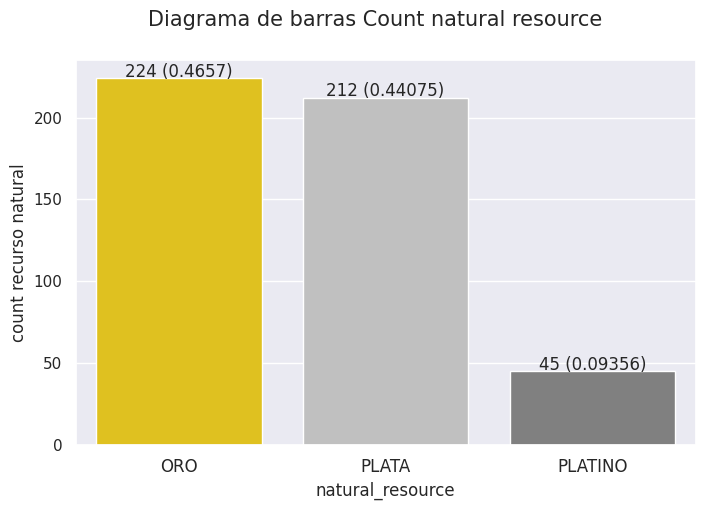

In [113]:
paleta = {
    'ORO': 'gold',
    'PLATA': 'silver',
    'PLATINO': 'gray'
}

plot_bar(data_transaccion, paleta=paleta, ejeX='natural_resource',ejey='count recurso natural',title='Count natural resource', p=True)

# **Encoders and Standardization**
---

**Data Trainer**

In [114]:
category_columns = X_train.select_dtypes(include=['object']).columns.to_list()
numeric_columns = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()

In [115]:
preprocessor = ColumnTransformer(
    [
        ('standard', StandardScaler(), numeric_columns),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), category_columns)
    ],  remainder='passthrough'
)

In [116]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

**Data Validation**

In [117]:
X_validation = preprocessor.transform(X_validation)

# **Model**
---

For this phase, classic models such as Logistic Regression (LR), Gaussian Naive Bayes (GB), K-Nearest Neighbors (KNN), Support Vector Classifier (SVC), and Decision Tree (DT) were used.

In [118]:
index = ['Data Train', 'Data Test', 'Data Validation']

results_no_dt = pd.DataFrame(index=index)

A list was generated with the instances of the first four models mentioned, configured with the default parameters, which are suitable for problems where the relationship between predictors is typically linear.


In [119]:
list_models = [
    ('LR',LogisticRegression(random_state=random_seed)),
    ('GB',GaussianNB()),
    ('KNN',KNeighborsClassifier()),
    ('SVC', SVC(probability=True, random_state=random_seed)),
]

The other list consists of decision trees with low depth (stumps)

In [120]:
list_models_dt = [
    ('DT1',DecisionTreeClassifier(criterion='entropy',max_depth=2, random_state=random_seed)),
    ('DT2',DecisionTreeClassifier(criterion='entropy',max_depth=1, random_state=random_seed)),
    ('DT3',DecisionTreeClassifier(criterion='entropy',max_depth=3, random_state=random_seed)),
]

For voting, whether soft voting or hard voting, it is necessary to assign a weight, which for this experiment will be the F1-score metric, giving importance to the three classes.

In [121]:
def generate_score(list_models:list):
  scores = []
  models_m = []
  for model in list_models:
    m = model[1]
    m.fit(X_train_preprocessed, y_train)
    models_m.append((model[0], m))
    y_predict = m.predict(X_test_preprocessed)
    score = f1_score(y_test, y_predict, average='micro')
    scores.append(score)
  return scores, models_m

In [122]:
scores, models_m = generate_score(list_models)

# **Voting-Hard**
---

In [123]:
ensembleVotingHard = VotingClassifier(estimators=list_models, weights=scores, flatten_transform = True, voting='hard')
ensembleVotingHard.fit(X_train_preprocessed, y_train)
y_predTrHard = ensembleVotingHard.predict(X_train_preprocessed)
y_predTeHard = ensembleVotingHard.predict(X_test_preprocessed)
y_predVaHard = ensembleVotingHard.predict(X_validation)

f1_score_hard_train =f1_score(y_train, y_predTrHard, average='micro')
f1_score_hard_test  =f1_score(y_test, y_predTeHard, average='micro')
f1_score_hard_vali  =f1_score(y_validation, y_predVaHard, average='micro')
f1_score_hard_train, f1_score_hard_test, f1_score_hard_vali

(0.8125, 0.7010309278350515, 0.7336956521739131)

In [124]:
results_no_dt['score_vouting_hard'] = [f1_score_hard_train, f1_score_hard_test, f1_score_hard_vali]

# **Voting-Soft**
---

In [125]:
ensembleVotingSoft = VotingClassifier(estimators=list_models, weights=scores, flatten_transform = True, voting='soft')
ensembleVotingSoft.fit(X_train_preprocessed, y_train)
y_predTrSoft = ensembleVotingSoft.predict(X_train_preprocessed)
y_predTeSoft = ensembleVotingSoft.predict(X_test_preprocessed)
y_predVaSoft = ensembleVotingSoft.predict(X_validation)

f1_score_soft_train =f1_score(y_train, y_predTrSoft, average='micro')
f1_score_soft_test  =f1_score(y_test, y_predTeSoft, average='micro')
f1_score_soft_vali  =f1_score(y_validation, y_predVaSoft, average='micro')
f1_score_soft_train, f1_score_soft_test, f1_score_soft_vali

(0.8463541666666666, 0.7731958762886598, 0.7608695652173914)

In [126]:
results_no_dt['score_vouting_soft'] = [f1_score_soft_train, f1_score_soft_test, f1_score_soft_vali]

In [127]:
for model in models_m:
  m = model[1]
  y_predTr = m.predict(X_train_preprocessed)
  y_predTe = m.predict(X_test_preprocessed)
  y_predVa = m.predict(X_validation)

  f1_score_train =f1_score(y_train, y_predTr, average='micro')
  f1_score_test  =f1_score(y_test, y_predTe, average='micro')
  f1_score_vali  =f1_score(y_validation, y_predVa, average='micro')
  f1_score_train, f1_score_test, f1_score_vali

  print(model[0], f1_score_train, f1_score_test, f1_score_vali)
  results_no_dt[model[0]] = [f1_score_train, f1_score_test, f1_score_vali]

LR 0.7838541666666666 0.7628865979381443 0.7010869565217391
GB 0.4895833333333333 0.4536082474226804 0.42934782608695654
KNN 0.8098958333333334 0.6597938144329897 0.7065217391304348
SVC 0.7005208333333334 0.4948453608247423 0.5815217391304348


In [128]:
results_no_dt

,score_vouting_hard,score_vouting_soft,LR,GB,KNN,SVC
Data Train,0.81250,0.84635,0.78385,0.48958,0.80990,0.70052
Data Test,0.70103,0.77320,0.76289,0.45361,0.65979,0.49485
Data Validation,0.73370,0.76087,0.70109,0.42935,0.70652,0.58152


- It is evident that the model assembled from the four models performs better on all three types of datasets than they do individually.

- It has an acceptable performance for predicting whether it is GOLD, SILVER, or PLATINUM, with limited configurations.

- The model with the most influence in the voting is Logistic Regression. This is evident from the prediction score of the "test" dataset, as it was used as the weight of importance.

- This model will tend to bias the predictions.

In [129]:
scores, models_m = generate_score(list_models_dt)

In [130]:
index = ['Data Train', 'Data Test', 'Data Validation']

results_dt = pd.DataFrame(index=index)

# **Voting-Hard**
---

In [131]:
ensembleVotingHard = VotingClassifier(estimators=list_models_dt, weights=scores, flatten_transform = True, voting='hard')
ensembleVotingHard.fit(X_train_preprocessed, y_train)
y_predTrHard = ensembleVotingHard.predict(X_train_preprocessed)
y_predTeHard = ensembleVotingHard.predict(X_test_preprocessed)
y_predVaHard = ensembleVotingHard.predict(X_validation)

f1_score_hard_train =f1_score(y_train, y_predTrHard, average='micro')
f1_score_hard_test  =f1_score(y_test, y_predTeHard, average='micro')
f1_score_hard_vali  =f1_score(y_validation, y_predVaHard, average='micro')
f1_score_hard_train, f1_score_hard_test, f1_score_hard_vali

(0.8489583333333334, 0.8144329896907216, 0.8043478260869565)

In [132]:
results_dt['score_vouting_hard'] = [f1_score_hard_train, f1_score_hard_test, f1_score_hard_vali]

# **Voting-Soft**
---

In [133]:
ensembleVotingSoft = VotingClassifier(estimators=list_models_dt, weights=scores, flatten_transform = True, voting='soft')
ensembleVotingSoft.fit(X_train_preprocessed, y_train)
y_predTrSoft = ensembleVotingSoft.predict(X_train_preprocessed)
y_predTeSoft = ensembleVotingSoft.predict(X_test_preprocessed)
y_predVaSoft = ensembleVotingSoft.predict(X_validation)

f1_score_soft_train =f1_score(y_train, y_predTrSoft, average='micro')
f1_score_soft_test  =f1_score(y_test, y_predTeSoft, average='micro')
f1_score_soft_vali  =f1_score(y_validation, y_predVaSoft, average='micro')
f1_score_soft_train, f1_score_soft_test, f1_score_soft_vali

(0.8489583333333334, 0.8144329896907216, 0.8043478260869565)

In [134]:
results_dt['score_vouting_soft'] = [f1_score_soft_train, f1_score_soft_test, f1_score_soft_vali]

In [135]:
for model in models_m:
  m = model[1]
  y_predTr = m.predict(X_train_preprocessed)
  y_predTe = m.predict(X_test_preprocessed)
  y_predVa = m.predict(X_validation)

  f1_score_train =f1_score(y_train, y_predTr, average='micro')
  f1_score_test  =f1_score(y_test, y_predTe, average='micro')
  f1_score_vali  =f1_score(y_validation, y_predVa, average='micro')
  f1_score_train, f1_score_test, f1_score_vali
  results_dt[model[0]] = [f1_score_train, f1_score_test, f1_score_vali]
  print(model[0], f1_score_train, f1_score_test, f1_score_vali)


DT1 0.8489583333333334 0.8144329896907216 0.8043478260869565
DT2 0.8489583333333334 0.8144329896907216 0.8043478260869565
DT3 0.921875 0.9072164948453608 0.8586956521739131


In [136]:
results_dt

,score_vouting_hard,score_vouting_soft,DT1,DT2,DT3
Data Train,0.84896,0.84896,0.84896,0.84896,0.92188
Data Test,0.81443,0.81443,0.81443,0.81443,0.90722
Data Validation,0.80435,0.80435,0.80435,0.80435,0.85870


- The decision trees have better performance, so none of them significantly biases the prediction.

- But they also don't show a significant improvement when assembled, although they perform better than the previous group.

# **Info**
---
**@By**: **Steven Bernal**

**@Nickname**: **Kaiziferr**

**@Git**: https://github.com/Kaiziferr